# **1. Pacotes**

Exemplo de fórmula que dá para colocar: $\mathrm{e}^{i \pi} - 1 = 0$

In [ ]:
'mvtnorm','gridExtra','ggrepel','splines2','keras','tictoc',,'glmnet'),dependencies = T)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘TTR’, ‘lazyeval’, ‘classInt’, ‘s2’, ‘units’, ‘quadprog’, ‘quantmod’, ‘SparseM’, ‘MatrixModels’, ‘beeswarm’, ‘vipor’, ‘RcppTOML’, ‘here’, ‘config’, ‘tfautograph’, ‘rex’, ‘sf’, ‘lpSolve’, ‘textshaping’, ‘iterators’, ‘zoo’, ‘timeSeries’, ‘timeDate’, ‘tseries’, ‘chron’, ‘tis’, ‘RUnit’, ‘abc.data’, ‘quantreg’, ‘locfit’, ‘egg’, ‘Rcpp’, ‘vdiffr’, ‘prettydoc’, ‘ggbeeswarm’, ‘RcppArmadillo’, ‘tinytest’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’, ‘tfdatasets’, ‘png’, ‘jpeg’, ‘tweenr’, ‘magick’, ‘covr’, ‘transformr’, ‘av’, ‘gifski’, ‘ragg’, ‘foreach’, ‘shape’, ‘RcppEigen’, ‘lars’


Warning message in install.packages(c("xts", "abc", "babynames", "mvtnorm", "gridExtra", :
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages(c("xts", "abc", "babynames", "mvtnorm", "gridExtra", :
“installation of package ‘a

In [ ]:
library(xts)
require("mvtnorm")
require("MASS")
require("tidyverse")
require("abc")
library(ggplot2)
require(gridExtra)
library(dplyr)
library(ggrepel)
library(tidyr)
library(splines2)
library(keras)
library(tensorflow)
options(repr.plot.width=10, repr.plot.height=8)

library(tictoc)
library(glmnet)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: mvtnorm

Loading required package: MASS

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks xts::first()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::last()   masks xts::last()
✖ dplyr::select() masks MASS::select()

Loading required package: abc

Loading required package: abc.data

Loading required package: nnet

Loading required package: quantreg

Loading 

# **2. Exemplo Normal Bivariada**

## **2.0. Geração dos dados**

In [ ]:
k <- 2
n <- 10000
rho <- .9
Sigma <- matrix(c(1, rho, rho, 1), 2)  # Matrix de correlação de (s_1, s_2)
ss.obs = rep(2.5, 2)
rej.tol = 0.1
m.gibbs <- 5000

theta.syn <- matrix(runif(n*k, -10, 10), ncol=k)
#plot(theta.syn)
ss.syn <- map_df(1:n,
                 ~data.frame(rmvnorm(1, theta.syn[., ], sigma=Sigma)))
#plot(ss.syn)

rejfit <- abc(target = ss.obs,
              param = theta.syn,
              sumstat = ss.syn,
              tol = rej.tol,
              method="loclinear")
#plot(rejfit, theta.syn)

resultados_abc<-data.frame(rejfit$adj.values)

Warning message:
“All parameters are "none" transformed.”
Warning message in abc(target = ss.obs, param = theta.syn, sumstat = ss.syn, tol = rej.tol, :
“No parameter names are given, using P1, P2, ...”


## **2.1. Algoritmos**

###**2.1.1. Algoritmo 1 - Rodrigues (2019)** 

In [ ]:
### Gibbs usando modelos lineares
mu1.algoritmo1 <- lm(theta.syn[, 1] ~ ss.syn[, 1] + ss.syn[, 2] + theta.syn[, 2])
mu2.algoritmo1 <- lm(theta.syn[, 2] ~ ss.syn[, 1] + ss.syn[, 2] + theta.syn[, 1])

theta <- matrix(, m.gibbs, 2)
theta[1, 1] <- 0
theta[1, 2] <- 0
for (i in 2:m.gibbs) {
  theta[i, 1] <- coef(mu1.algoritmo1) %*% c(1, ss.obs, theta[i - 1, 2]) + sample(residuals(mu1.algoritmo1), 1)
  theta[i, 2] <- coef(mu2.algoritmo1) %*% c(1, ss.obs, theta[i, 1]) + sample(residuals(mu2.algoritmo1), 1)
}

###**2.1.2. Algoritmo 2 - Rodrigues (2019) + PCA** 

In [ ]:
theta_syn<-data.frame(theta.syn)
regM1 <- as.data.frame(cbind(ss.syn,theta_syn))
#regM1 <- as.data.frame(cbind(ss.syn,theta.syn))
names(regM1) <- c("s1", "s2", "theta1", "theta2")

#pca
  
  w=rejfit$weights
  X=as.matrix(regM1[,3:4])
  
  #aplicando a tecnica:
  mu = c()
  for(i in 1:ncol(X)) mu[i] = 1/sum(w)*sum(w*X[,i])
  XCenter = X
  for(i in 1:ncol(X)) XCenter[,i] = X[,i] - mu[i]
  
  wX = matrix(NA, nc = ncol(X), nr = nrow(X))
  for(i in 1:ncol(X)) wX[,i] = w*X[,i]  
  XtWX = t(X)%*%wX
  XCov = 1/sum(w)*XtWX
  
  modPca = prcomp(XCov)
  
  #Aplicando transformação
  wpca= X%*%modPca$rotation
  
  # Agrupando Dados com thetas transformados
  
  regM <- as.data.frame(cbind(ss.syn,wpca,w))
  names(regM) <- c("s1", "s2", "theta1", "theta2","pesos")
  
#plot(rejfit, theta.syn)

  ### Gibbs usando modelos lineares
  mu1.algoritmo2 <- lm(theta1 ~ s1 + s2 + theta2,data=regM)
  mu2.algoritmo2 <- lm(theta2 ~ s1 + s2 + theta1,data=regM)
  
  theta_algoritmo2 <- matrix(,m.gibbs, 2)
  theta_algoritmo2[1, 1] <- 0
  theta_algoritmo2[1, 2] <- 0
  for (i in 2:m.gibbs) {
    theta_algoritmo2[i, 1] <- coef(mu1.algoritmo2) %*% c(1, ss.obs, theta_algoritmo2[i - 1, 2]) + sample(residuals(mu1.algoritmo2), 1)
    theta_algoritmo2[i, 2] <- coef(mu2.algoritmo2) %*% c(1, ss.obs, theta_algoritmo2[i, 1]) + sample(residuals(mu2.algoritmo2), 1)
  }
  
  #reverter os valores transformados
  
  transformada=data.matrix(theta_algoritmo2)
  theta_algoritmo2=t(t(transformada %*% t(modPca$rotation)))
  names(theta_algoritmo2) <- c("theta1", "theta2")

###**2.1.3. Algoritmo 3 - Rodrigues (2019) + Regressão linear + Aproximação por fatorações a posteriori** 

In [ ]:
regM1 <- as.data.frame(cbind(ss.syn,theta.syn))
names(regM1) <- c("s1", "s2", "theta1", "theta2")

mu1.algoritmo3 <- lm(theta1 ~ s1 + s2,data=regM1)
mu2.algoritmo3 <- lm(theta2 ~ s1 + s2 + theta1,data=regM1)

fatoracoes<-5000
theta_algoritmo3 =  data.frame(matrix(NA, fatoracoes, nc = 4))
names(theta_algoritmo3) = c('s1', 's2', 'theta1', 'theta2')
theta_algoritmo3[,1:2] = rep(c(2.5,2.5), fatoracoes)
theta_algoritmo3[1,3:4] = c(0, 0)

theta_algoritmo3[c(2:fatoracoes), 3] <- as.numeric(coef(mu1.algoritmo3) %*% c(1, as.numeric(theta_algoritmo3[1,1:2]))) + as.numeric(sample(residuals(mu1.algoritmo3), size=dim(theta_algoritmo3)[1]-1,replace=T))

theta_algoritmo3[, 4] <- cbind(matrix(rep(1,fatoracoes),ncol=1),as.matrix(theta_algoritmo3[,1:3])) %*% as.numeric(coef(mu2.algoritmo3)) + matrix(sample(residuals(mu2.algoritmo3), fatoracoes),ncol=1)

#for(i in 2:fatoracoes){
#  theta_algoritmo3[i, 4] <- coef(mu2.algoritmo3) %*% c(1, as.numeric(theta_algoritmo3[i,1:3])) + sample(residuals(mu1.algoritmo3), 1)
#  }

theta_algoritmo3<-data.frame(as.matrix(theta_algoritmo3[,c(3,4)]))
colnames(theta_algoritmo3)<-c('X1','X2')

###**2.1.4. Algoritmo 4 - Rodrigues (2019) + Redes Neurais + Aproximação por fatorações a posterior** 

In [ ]:
# data split ===================================================================

n=nrow(regM1)
#Separacao base de treino e validacao
indextrain <- sample(1:n,round(0.8*n),replace=FALSE)
base_train <- regM1[ indextrain,]
base_test <- regM1[-indextrain,]
base_train <- regM1[ indextrain,]
base_test <- regM1[-indextrain,]

#Dados para estimar Theta1

Xtrain <- base_train[,c(1:2)]#tirar o 4
Xtest <- base_test[,c(1:2)]#tirar o 4
Ytrain <- base_train[,3]
Ytest <- base_test[,3]

#.....................................................
#Dados para estimar Theta2

Xtrain2 <- base_train[,c(1:3)]
Xtest2 <- base_test[,c(1:3)]
Ytrain2 <- base_train[,4]
Ytest2 <- base_test[,4]

#===============================================================================

# ajuste regressao quantilica com redes neurais ================================
fitRq = function(x, y, xtest, ytest,tau) {
  
  x = as.matrix(x)
  y = as.matrix(y)
  xtest=as.matrix(xtest)
  ytest=as.matrix(ytest)
  
  #funcao de perda
  tilted_loss = function(q, y, f) {
    e = y - f
    return(k_mean(k_maximum(q * e, (q - 1) * e)))
  }
  
  model = keras_model_sequential() %>%
    
    layer_dense(units = 128, activation = 'relu', input_shape = ncol(x)) %>%
    layer_dense(units = 64, activation = 'relu') %>%
    layer_dense(units = 32, activation = 'relu') %>%
    layer_dense(units = 16, activation = 'relu') %>%
    layer_dense(units = length(tau))
  
  
  model %>% compile(optimizer = 'adam',
                    loss = function(y, yP) return(tilted_loss(tau, y, yP)),
                    metrics = "mae")
  
  model %>% fit(x, y,
                batch_size = 32,
                epochs = 30,
                verbose = F,
                validation_data = list(xtest, ytest))
  
  return(model)
}

predictRq = function(fitModel, x, tau) {
  
  x = as.matrix(x)
  
  yHat = fitModel %>% predict(x)
  colnames(yHat) = paste0('quantile= ', tau)
  
  return(yHat)
}
#===============================================================================

# ajuste do modelo =============================================================
#Definição do Grid
gTau = seq(-6,6,0.1)#função logito
#Transformação Logito
tau = 1/(1+exp(-gTau))
#tau =c(.1,.1,.1,.1,.1)
fitTheta1 = fitRq(x = Xtrain,
                  y = Ytrain,
                  xtest=Xtest,
                  ytest=Ytest,
                  tau = tau)

fitTheta2 = fitRq(x = Xtrain2,
                  y = Ytrain2,
                  xtest=Xtest2,
                  ytest=Ytest2,
                  tau = tau)
#===============================================================================

# fatoração ========================================================================
outG =  data.frame(matrix(NA, m.gibbs, nc = 4))
names(outG) = c('s1', 's2', 'theta1', 'theta2')
#valor inicial s0:
outG[,1:2] = rep(c(2.5,2.5), m.gibbs)
#valor inicial para theta:
outG[1,3:4] = c(0, 0)

#obtencao dos valores preditos pelo modelo:
thetaHat1 = predictRq(fitTheta1, matrix(c(2.5,2.5),ncol=2), tau)
x = as.numeric(thetaHat1)
u = runif(m.gibbs, .0, 1)
gu = log(u/(1-u))
outG$theta1 = splinefun(x = gTau, y = x,method ="monoH.FC")(gu)

for(i in 1:m.gibbs){
  #theta2:
  #obtencao dos valores preditos pelo modelo:
  thetaHat2 = predictRq(fitTheta2, outG[i,c(1:3)], tau)
  x = as.numeric(thetaHat2)
  u = runif(1, .0, 1)
  gu = log(u/(1-u))
 outG$theta2[i] = splinefun(x = gTau, y = x,method ="monoH.FC")(gu)
}
theta_algoritmo4<-outG[,c(3,4)]
colnames(theta_algoritmo4)<-c('X1','X2')

In [ ]:
head(theta_algoritmo4)

,X1,X2
,<dbl>,<dbl>
1,2.321568,2.163902
2,4.455561,4.638447
3,4.575688,3.875465
4,3.450430,2.196398
5,3.661779,4.333685
6,2.962978,2.258610


##**2.2. Gráficos**

### **2.2.1. Medidas descritivas da posteriori**

In [ ]:

data.frame(algoritmo=c('algoritmo1','algoritmo1','algoritmo2','algoritmo2','algoritmo3','algoritmo3','algoritmo4','algoritmo4'),variavel=c('X1','X2','X1','X2','X1','X2','X1','X2'),media=c(mean(theta[,1]),
mean(theta[,2]),
mean(theta_algoritmo2[,1]),
mean(theta_algoritmo2[,2]),
mean(theta_algoritmo3[,1]),
mean(theta_algoritmo3[,2]),
mean(theta_algoritmo4[,1]),
mean(theta_algoritmo4[,2])),
desvio_padrao=c(sd(theta[,1]),
sd(theta[,2]),
sd(theta_algoritmo2[,1]),
sd(theta_algoritmo2[,2]),
sd(theta_algoritmo3[,1]),
sd(theta_algoritmo3[,2]),
sd(theta_algoritmo4[,1]),
sd(theta_algoritmo4[,2])
),
MSE=c(mean((theta[,1]-2.5)^2),mean((theta[,2]-2.5)^2),mean((theta_algoritmo2[,1]-2.5)^2),mean((theta_algoritmo2[,2]-2.5)^2),
mean((theta_algoritmo3[,1]-2.5)^2),mean((theta_algoritmo3[,2]-2.5)^2),mean((theta_algoritmo4[,1]-2.5)^2),mean((theta_algoritmo4[,2]-2.5)^2)))

algoritmo,variavel,media,desvio_padrao,MSE
<chr>,<chr>,<dbl>,<dbl>,<dbl>
algoritmo1,X1,2.337971,1.0003815,1.0268163
algoritmo1,X2,2.338694,1.0041042,1.0340432
algoritmo2,X1,2.372916,0.9804516,0.9772433
algoritmo2,X2,2.376089,0.9834842,0.9824018
algoritmo3,X1,2.364819,0.9777974,0.9741704
algoritmo3,X2,2.360451,0.9799034,0.9794926
algoritmo4,X1,2.621299,1.0611030,1.1404278
algoritmo4,X2,2.510171,1.0353683,1.0718766


### **2.2.2. Amostras das distribuições a priori**

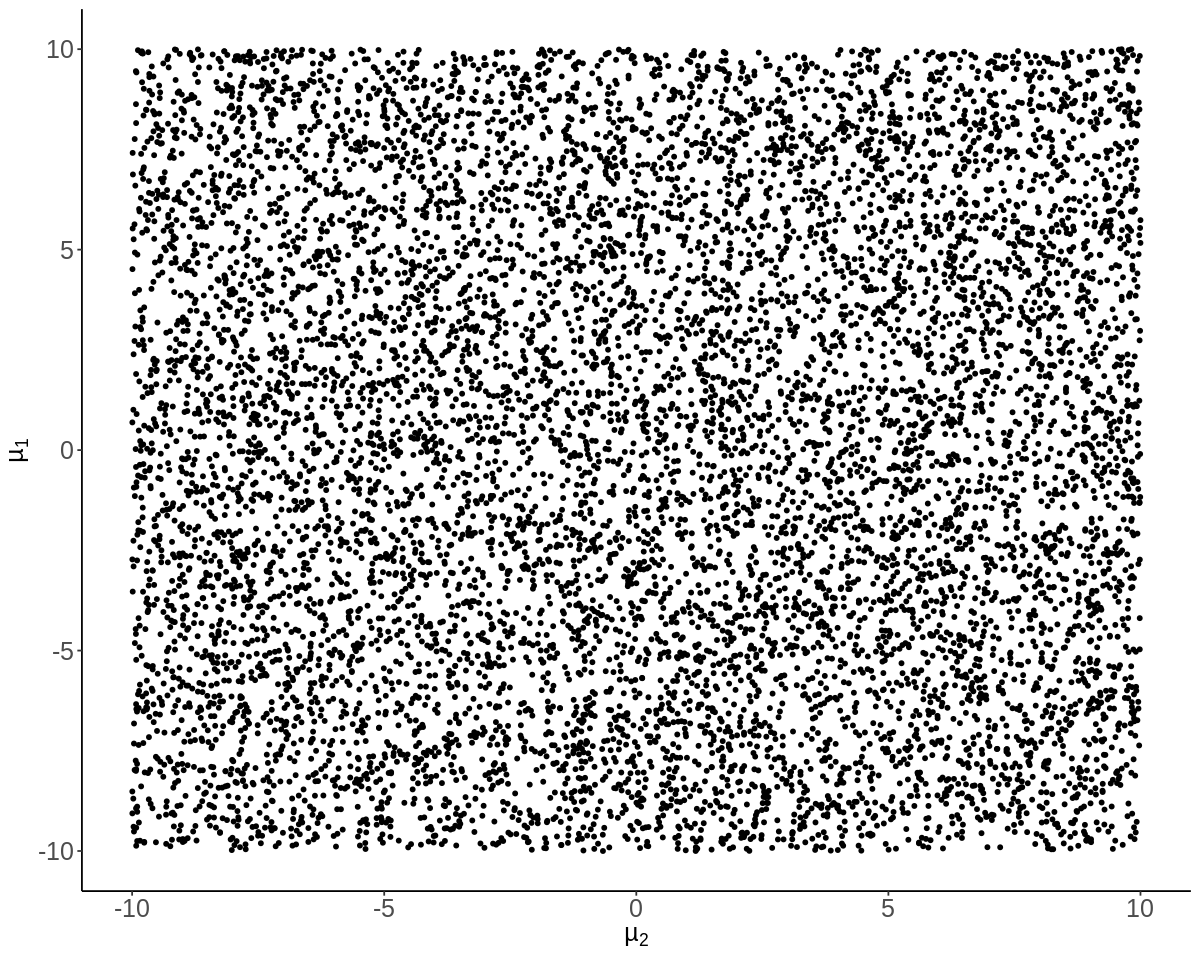

In [ ]:
theta.syn_dataframe<-data.frame(theta.syn)
#plot(theta.syn,cex=0.05,main='Original')
#expression(theta[1])
ggplot(theta.syn_dataframe, aes(x=X1, y=X2)) + 
    geom_point(size=1,alpha = 1)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(y=expression(mu[1]),x=expression(mu[2]))

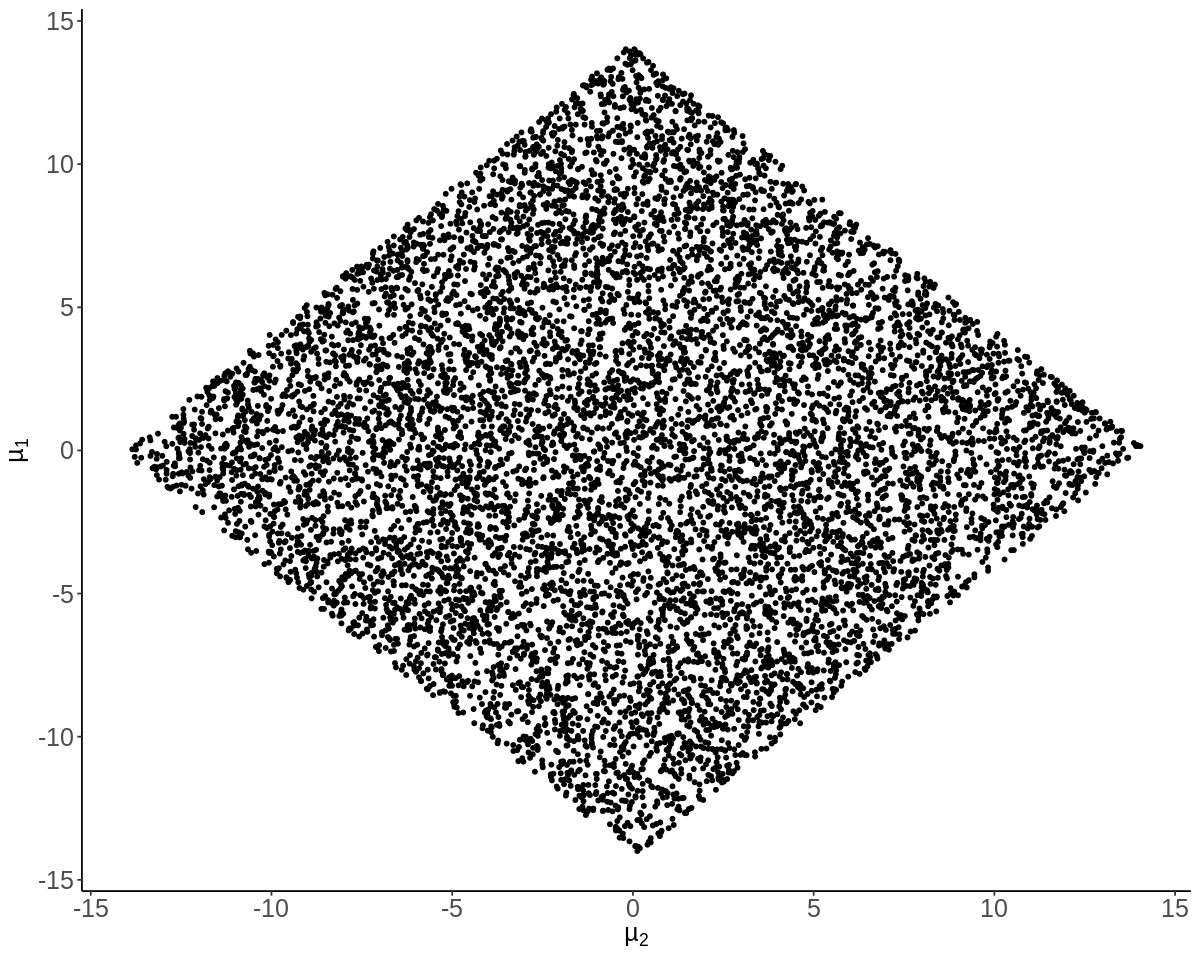

In [ ]:
ggplot(regM[,3:4], aes(x=theta1, y=theta2)) + 
    geom_point(size=1,alpha = 1)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(y=expression(mu[1]),x=expression(mu[2]))

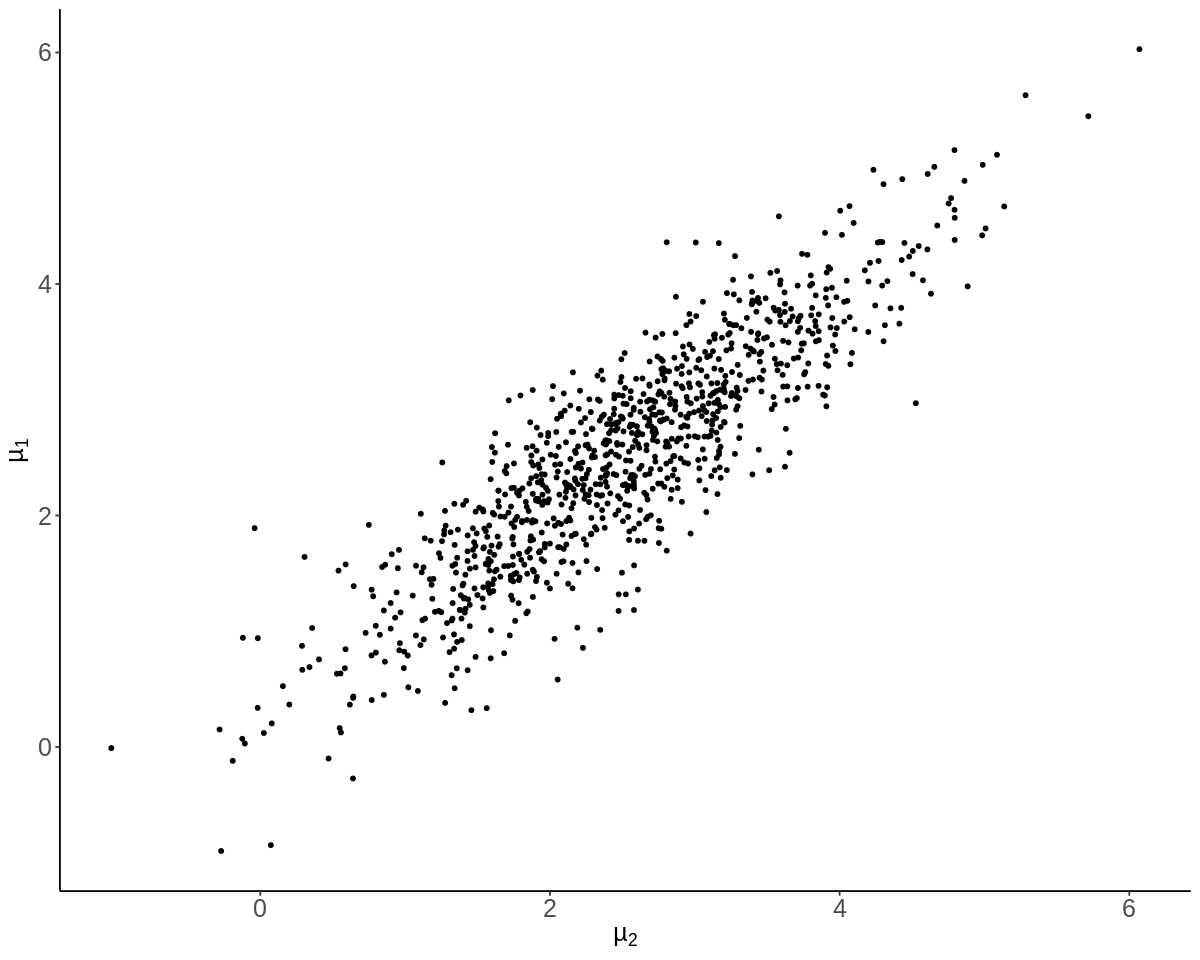

In [ ]:
ggplot(resultados_abc, aes(x=X1, y=X2)) + 
    geom_point(size=1,alpha = 1)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(y=expression(mu[1]),x=expression(mu[2]))

In [ ]:
head(regM)

,s1,s2,theta1,theta2,pesos
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-8.168698,-7.194123,0.8830346,-10.7998689,0.43831987
2,-3.823038,3.227173,4.6750271,-1.5099378,0.36594805
3,-7.493237,4.924015,9.2409938,-0.7867766,0.24891669
4,4.934361,3.609605,-1.2171697,3.6686974,0.66536757
5,8.499204,-1.607196,-7.0713574,6.4293938,0.13132352
6,-5.910565,-4.355532,1.4227054,-8.8260911,0.05899558


In [ ]:
ggplot(regM, aes(x=theta1_abc, y=theta2_abc)) + 
    geom_point(size=1,alpha = 1)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(y=expression(mu[1]),x=expression(mu[2]))

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'theta1_abc' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(pr

ERROR: ignored

plot without title

### **2.2.3. Densidades das distribuições a prioris**

In [ ]:
ggplot(data.frame(theta.syn), aes(x=X1)) +geom_histogram(aes(y = ..density..), colour= "black", fill = "grey")+
    geom_density(fill="blue", alpha = .2)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(mu[1]),y='Densidade')

In [ ]:
ggplot(data.frame(theta.syn), aes(x=X2)) +geom_histogram(aes(y = ..density..), colour= "black", fill = "grey")+
    geom_density(fill="blue", alpha = .2)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(mu[2]),y='Densidade')

In [ ]:
ggplot(data.frame(regM[,c(3,4)]), aes(x=theta1)) +geom_histogram(aes(y = ..density..), colour= "black", fill = "grey")+
    geom_density(fill="blue", alpha = .2)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(mu[1]),y='Densidade')

In [ ]:
ggplot(data.frame(regM[,c(3,4)]), aes(x=theta2)) +geom_histogram(aes(y = ..density..), colour= "black", fill = "grey")+
    geom_density(fill="blue", alpha = .2)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(mu[2]),y='Densidade')

### **2.2.4. Distribuição a posteriori**

#### **2.2.4.1. Individuais** 

In [ ]:
ggplot(data.frame(resultados_abc),aes(x=X1, y=X2))+
  geom_point()+geom_density_2d(size=1.5,col='red')+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 6.5)+ylim(-3.5, 6.5)

In [ ]:
ggplot(data.frame(theta),aes(x=X1, y=X2))+
  geom_point()+geom_density_2d(size=1.5,col='red')+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 6.5)+ylim(-3.5, 6.5)

In [ ]:
ggplot(data.frame(theta_algoritmo2),aes(x=X1, y=X2))+
  geom_point()+geom_density_2d(size=1.5,col='red')+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 6.5)+ylim(-3.5, 6.5)

In [ ]:
ggplot(data.frame(theta_algoritmo3),aes(x=X1, y=X2))+
  geom_point()+geom_density_2d(size=1.5,col='red')+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 6.5)+ylim(-3.5, 6.5)

In [ ]:
ggplot(data.frame(theta_algoritmo4),aes(x=X1, y=X2))+
  geom_point()+geom_density_2d(size=1.5,col='red')+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-2.5, 6.5)+ylim(-3.5, 6.5)

#### **2.2.4.2. Conjuntas** 

In [ ]:
#com os 3 algoritmos
juntos<-rbind(data.frame(theta,categoria='Algoritmo 1'),rbind(data.frame(theta_algoritmo2,categoria='Algoritmo 2'),rbind(data.frame(theta_algoritmo3,categoria='Algoritmo 3'))))

#com os 4 algoritmos
#juntos<-rbind(data.frame(theta,categoria='Algoritmo 1'),rbind(data.frame(theta_algoritmo2,categoria='Algoritmo 2'),rbind(data.frame(theta_algoritmo3,categoria='Algoritmo 3'),data.frame(theta_algoritmo4,categoria='Algoritmo 4'))))

ggplot(juntos,aes(x=X1, y=X2,colour=factor(categoria)))+
  geom_point()+
  theme_bw()+
  geom_density_2d(aes(group = categoria),col='white')+ labs(colour = "Algoritmos",x=expression(theta[1]),y=expression(theta[2]))

### **2.2.5. Densidades condicionais da posteriori**

In [ ]:
juntos2<-juntos
real<-data.frame(X1=rnorm(5000,mean=2.5,1),
                 X2=rnorm(5000,mean=2.5,1),
                 categoria='Real')
juntos2<-rbind(juntos2,real)

In [ ]:
ggplot(juntos2, aes(X1, colour = categoria)) +
  geom_density()+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y='Densidade',colour='Algoritmo')

In [ ]:
ggplot(juntos2, aes(X2, colour = categoria)) +
  geom_density()+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y='Densidade',colour='Algoritmo')

### **2.2.6. Movimentação da cadeia**

#### **2.2.6.1. Começo da cadeia**

In [ ]:
b<-data.frame(theta)[c(1:50),]
b$lagx2<-c(b$X2[2:50],NA)
b$lagx1<-c(b$X1[2:50],NA)

c<-data.frame(theta_algoritmo2)[c(1:50),]
c$lagx2<-c(c$X2[2:50],NA)
c$lagx1<-c(c$X1[2:50],NA)

d<-data.frame(theta_algoritmo3)[c(1:50),]
d$lagx2<-c(d$X2[2:50],NA)
d$lagx1<-c(d$X1[2:50],NA)

e<-data.frame(theta_algoritmo4)[c(1:50),]
e$lagx2<-c(e$X2[2:50],NA)
e$lagx1<-c(e$X1[2:50],NA)

In [ ]:
ggplot(b,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-0.25, 5.25)+ylim(-0.25, 5.25)+
   scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(c,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-0.25, 5.25)+ylim(-0.25, 5.25)+
   scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(d,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
  xlim(-0.25, 5.25)+ylim(-0.25, 5.25)+
   scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(e,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
   scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

#### **2.2.6.2. Meio da cadeia**

In [ ]:
meio_cadeia<-c(((dim(theta)[1]/2)-24):((dim(theta)[1]/2)+25))
b<-data.frame(theta)[c(meio_cadeia),]
b$lagx2<-c(b$X2[2:50],NA)
b$lagx1<-c(b$X1[2:50],NA)

c<-data.frame(theta_algoritmo2)[c(meio_cadeia),]
c$lagx2<-c(c$X2[2:50],NA)
c$lagx1<-c(c$X1[2:50],NA)

d<-data.frame(theta_algoritmo3)[c(meio_cadeia),]
d$lagx2<-c(d$X2[2:50],NA)
d$lagx1<-c(d$X1[2:50],NA)

e<-data.frame(theta_algoritmo4)[c(meio_cadeia),]
e$lagx2<-c(e$X2[2:50],NA)
e$lagx1<-c(e$X1[2:50],NA)

In [ ]:
ggplot(b,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
   scale_y_continuous(limits = c(-.5, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.5, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(c,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
   scale_y_continuous(limits = c(-.5, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.5, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(d,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
   scale_y_continuous(limits = c(-.5, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.5, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(e,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
   scale_y_continuous(limits = c(-.5, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.5, 5.25), breaks = seq(0, 5, by = 1))

#### **2.2.6.3. Final da cadeia**

In [ ]:
final_cadeia<-c((dim(theta)[1]-49):dim(theta)[1])
b<-data.frame(theta)[c(final_cadeia),]
b$lagx2<-c(b$X2[2:50],NA)
b$lagx1<-c(b$X1[2:50],NA)

c<-data.frame(theta_algoritmo2)[c(final_cadeia),]
c$lagx2<-c(c$X2[2:50],NA)
c$lagx1<-c(c$X1[2:50],NA)

d<-data.frame(theta_algoritmo3)[c(final_cadeia),]
d$lagx2<-c(d$X2[2:50],NA)
d$lagx1<-c(d$X1[2:50],NA)

e<-data.frame(theta_algoritmo4)[c(final_cadeia),]
e$lagx2<-c(e$X2[2:50],NA)
e$lagx1<-c(e$X1[2:50],NA)

In [ ]:
ggplot(b,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
   scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(c,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
   scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(d,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
   scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

In [ ]:
ggplot(e,aes(x=X1, y=X2))+
  geom_point(col='red',size=3)+geom_segment(aes(x=X1,y=X2,xend=X1,yend=lagx2))+
  geom_segment(aes(x=X1,y=lagx2,xend=lagx1,yend=lagx2),arrow = arrow(length = unit(0.5, "cm")))+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1))+
  labs(x=expression(theta[1]),y=expression(theta[2]))+
   scale_y_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))+
   scale_x_continuous(limits = c(-.25, 5.25), breaks = seq(0, 5, by = 1))

#### **3.5.4. A cada 200 observações**

In [ ]:
p<-data.frame(theta,indice=c(1:5000))
pa<-p[p$indice %in% c(1,seq(0,5000,200)[-1]),]

p2<-data.frame(theta_algoritmo2,indice=c(1:5000))
pa2<-p2[p2$indice %in% c(1,seq(0,5000,200)[-1]),]

p3<-data.frame(theta_algoritmo3,indice=c(1:5000))
pa3<-p3[p3$indice %in% c(1,seq(0,5000,200)[-1]),]

p4<-data.frame(theta_algoritmo4,indice=c(1:5000))
pa4<-p4[p4$indice %in% c(1,seq(0,5000,200)[-1]),]

grid.arrange(
ggplot(p,aes(x=X1, y=X2, label=indice))+
  geom_point(alpha=.2)+
  geom_text_repel(data=pa,color="red") +
  geom_segment(data=pa,color="red", 
               aes(
                 xend=c(tail(X1, n=-1), NA), 
                 yend=c(tail(X2, n=-1), NA)
               ),
               arrow=arrow(length=unit(0.3,"cm"))
  )+theme_bw()+
  xlim(-2.5, 6.5)+ylim(-3.5, 6.5)+ labs(x=expression(theta[1]),y=expression(theta[2]),title='Algoritmo 1'),

ggplot(p2,aes(x=X1, y=X2, label=indice))+
  geom_point(alpha=.2)+
  geom_text_repel(data=pa,color="red") +
  geom_segment(data=pa,color="red", 
               aes(
                 xend=c(tail(X1, n=-1), NA), 
                 yend=c(tail(X2, n=-1), NA)
               ),
               arrow=arrow(length=unit(0.3,"cm"))
  )+theme_bw()+
  xlim(-2.5, 6.5)+ylim(-3.5, 6.5)+ labs(x=expression(theta[1]),y=expression(theta[2]),title='Algoritmo 2'),
  
  ggplot(p3,aes(x=X1, y=X2, label=indice))+
  geom_point(alpha=.2)+
  geom_text_repel(data=pa,color="red") +
  geom_segment(data=pa,color="red", 
               aes(
                 xend=c(tail(X1, n=-1), NA), 
                 yend=c(tail(X2, n=-1), NA)
               ),
               arrow=arrow(length=unit(0.3,"cm"))
  )+theme_bw()+
  xlim(-2.5, 6.5)+ylim(-3.5, 6.5)+ labs(x=expression(theta[1]),y=expression(theta[2]),title='Algoritmo 3'),

  ggplot(p4,aes(x=X1, y=X2, label=indice))+
  geom_point(alpha=.2)+
  geom_text_repel(data=pa,color="red") +
  geom_segment(data=pa,color="red", 
               aes(
                 xend=c(tail(X1, n=-1), NA), 
                 yend=c(tail(X2, n=-1), NA)
               ),
               arrow=arrow(length=unit(0.3,"cm"))
  )+theme_bw()+
  xlim(-2.5, 6.5)+ylim(-3.5, 6.5)+ labs(x=expression(theta[1]),y=expression(theta[2]),title='Algoritmo 4'),

  ncol=2)

### **2.2.7. Distância euclidiana**

In [ ]:
distancias<-rbind(data.frame(sqrt((theta[,c(1,2)]-2.5)^2),categoria='Algoritmo 1'),data.frame(sqrt((theta_algoritmo2[,c(1,2)]-2.5)^2),categoria='Algoritmo 2'),
data.frame(sqrt((theta_algoritmo3[,c(1,2)]-2.5)^2),categoria='Algoritmo 3'),data.frame(sqrt((theta_algoritmo4[,c(1,2)]-2.5)^2),categoria='Algoritmo 4'))

ggplot(distancias,aes(x=X1, y=X2,colour=factor(categoria)))+
  geom_point()+
  theme_bw()

### **2.2.8. Convergência da cadeia**

In [ ]:
b<-distancias[distancias$categoria=='Algoritmo 1',]
no<-rbind(data.frame(valor=b$X1,x='X1'),data.frame(valor=b$X2,x='X2'))
no$distancia<-sqrt((no$valor-2.5)^2)
no$distancia_normal<-no$valor-2.5

b<-distancias[distancias$categoria=='Algoritmo 2',]
no2<-rbind(data.frame(valor=b$X1,x='X1'),data.frame(valor=b$X2,x='X2'))
no2$distancia<-sqrt((no2$valor-2.5)^2)
no2$distancia_normal<-no2$valor-2.5

b<-distancias[distancias$categoria=='Algoritmo 3',]
no3<-rbind(data.frame(valor=b$X1,x='X1'),data.frame(valor=b$X2,x='X2'))
no3$distancia<-sqrt((no3$valor-2.5)^2)
no3$distancia_normal<-no3$valor-2.5

b<-distancias[distancias$categoria=='Algoritmo 4',]
no4<-rbind(data.frame(valor=b$X1,x='X1'),data.frame(valor=b$X2,x='X2'))
no4$distancia<-sqrt((no4$valor-2.5)^2)
no4$distancia_normal<-no4$valor-2.5

no$indice<-rep(c(1:5000),2)
no2$indice<-rep(c(1:5000),2)
no3$indice<-rep(c(1:5000),2)
no4$indice<-rep(c(1:5000),2)
p<-no[no$x=='X1' & no$indice %in% c(1,seq(0,5000,100)[-1]),]
p2<-no[no$x=='X2' & no$indice %in% c(1,seq(0,5000,100)[-1]),]
p3<-no2[no2$x=='X1' & no2$indice %in% c(1,seq(0,5000,100)[-1]),]
p4<-no2[no2$x=='X2' & no2$indice %in% c(1,seq(0,5000,100)[-1]),]
p5<-no3[no3$x=='X1' & no3$indice %in% c(1,seq(0,5000,100)[-1]),]
p6<-no3[no3$x=='X2' & no3$indice %in% c(1,seq(0,5000,100)[-1]),]
p7<-no4[no4$x=='X1' & no4$indice %in% c(1,seq(0,5000,100)[-1]),]
p8<-no4[no4$x=='X2' & no4$indice %in% c(1,seq(0,5000,100)[-1]),]

grid.arrange(
  
ggplot(no[no$x=='X1',],aes(x=distancia, y=valor,label=indice))+
  geom_point()+
  geom_point(data=p,aes(x=distancia,y=valor),color='red',size=3)+
  geom_text_repel(data=p,aes(x=distancia,y=valor),color='red',size=3)+
  theme_bw()+
  labs(y=expression(theta[1]),x='distância do real',title='Algoritmo 1'),

ggplot(no[no$x=='X2',],aes(x=distancia, y=valor,label=indice))+
  geom_point()+
  geom_point(data=p2,aes(x=distancia,y=valor),color='red',size=3)+
  geom_text_repel(data=p2,aes(x=distancia,y=valor),color='red',size=3)+
  theme_bw()+
  labs(y=expression(theta[2]),x='distância do real',title='Algoritmo 1'),

ggplot(no2[no2$x=='X1',],aes(x=distancia, y=valor,label=indice))+
  geom_point()+
  geom_point(data=p3,aes(x=distancia,y=valor),color='red',size=3)+
  geom_text_repel(data=p3,aes(x=distancia,y=valor),color='red',size=3)+
  theme_bw()+
  labs(y=expression(theta[1]),x='distância do real',title='Algoritmo 2'),

ggplot(no2[no2$x=='X2',],aes(x=distancia, y=valor,label=indice))+
  geom_point()+
  geom_point(data=p4,aes(x=distancia,y=valor),color='red',size=3)+
  geom_text_repel(data=p4,aes(x=distancia,y=valor),color='red',size=3)+
  theme_bw()+
  labs(y=expression(theta[2]),x='distância do real',title='Algoritmo 2'),
  
ggplot(no3[no3$x=='X1',],aes(x=distancia, y=valor,label=indice))+
  geom_point()+
  geom_point(data=p5,aes(x=distancia,y=valor),color='red',size=3)+
  geom_text_repel(data=p5,aes(x=distancia,y=valor),color='red',size=3)+
  theme_bw()+
  labs(y=expression(theta[1]),x='distância do real',title='Algoritmo 3'),

ggplot(no3[no3$x=='X2',],aes(x=distancia, y=valor,label=indice))+
  geom_point()+
  geom_point(data=p6,aes(x=distancia,y=valor),color='red',size=3)+
  geom_text_repel(data=p6,aes(x=distancia,y=valor),color='red',size=3)+
  theme_bw()+
  labs(y=expression(theta[2]),x='distância do real',title='Algoritmo 3'), 

ggplot(no4[no4$x=='X1',],aes(x=distancia, y=valor,label=indice))+
  geom_point()+
  geom_point(data=p7,aes(x=distancia,y=valor),color='red',size=3)+
  geom_text_repel(data=p7,aes(x=distancia,y=valor),color='red',size=3)+
  theme_bw()+
  labs(y=expression(theta[1]),x='distância do real',title='Algoritmo 4'),

ggplot(no4[no4$x=='X2',],aes(x=distancia, y=valor,label=indice))+
  geom_point()+
  geom_point(data=p8,aes(x=distancia,y=valor),color='red',size=3)+
  geom_text_repel(data=p8,aes(x=distancia,y=valor),color='red',size=3)+
  theme_bw()+
  labs(y=expression(theta[2]),x='distância do real',title='Algoritmo 4')
  ,ncol=2)

#### **2.2.8.1. Densidade das distâncias euclidiana**

##### **3.7.1.1. De um ponto ao seu anterior**

In [ ]:
distancia_euclidiana_diff_algoritmo1<-sqrt(diff(data.frame(theta)$X1)^ 2+diff(data.frame(theta)$X2)^ 2)
distancia_euclidiana_ponto_algoritmo1<-sqrt((data.frame(theta)$X1-2.5)^ 2+(data.frame(theta)$X2-2.5)^ 2)

distancia_euclidiana_diff_algoritmo2<-sqrt(diff(data.frame(theta_algoritmo2)$X1)^ 2+diff(data.frame(theta_algoritmo2)$X2)^ 2)
distancia_euclidiana_ponto_algoritmo2<-sqrt((data.frame(theta_algoritmo2)$X1-2.5)^ 2+(data.frame(theta_algoritmo2)$X2-2.5)^ 2)

distancia_diff<-data.frame(distancia=c(distancia_euclidiana_diff_algoritmo1,distancia_euclidiana_diff_algoritmo2),categoria=c(rep('algoritmo1',4999),rep('algoritmo2',4999)))

ggplot(distancia_diff, aes(distancia, colour = categoria)) +
  geom_density()+theme_bw()

##### **3.7.1.2. De um ponto ao ponto verdadeiro**

In [ ]:
distancia_centro<-data.frame(distancia=c(distancia_euclidiana_ponto_algoritmo1,distancia_euclidiana_ponto_algoritmo2),categoria=c(rep('algoritmo1',5000),rep('algoritmo2',5000)))

ggplot(distancia_centro, aes(distancia, colour = categoria)) +
  geom_density()+theme_bw()

#### **2.2.8.2. Distância euclidiana ao longo das iterações**

##### **2.2.8.2.1. De um ponto ao seu anterior**

In [ ]:
distancia_diff$indice<-c(rep(c(1:4999),2))

ggplot(data=distancia_diff, aes(x=indice, y=distancia)) +
  geom_line()+theme_bw()+facet_grid(.~ categoria )+theme_bw()


##### **2.2.8.2.2. De um ponto ao ponto verdadeiro**

In [ ]:
distancia_centro$indice<-c(rep(c(1:5000),2))
distancia_centro$media_movel<-c(rep(NA,10),diff(distancia_centro[distancia_centro$categoria=='algoritmo1',]$distancia,10),
                                rep(NA,10),diff(distancia_centro[distancia_centro$categoria=='algoritmo2',]$distancia,10))
ggplot(data=distancia_centro, aes(x=indice, y=distancia)) +
  geom_line()+theme_bw()+facet_grid(.~ categoria )+theme_bw()

### **2.2.9. Gráfico da ACF**

In [ ]:
acf(theta[,1],main=paste0('ACF de ',expression(theta[1]),' - Algoritmo 1'))

In [ ]:
acf(theta_algoritmo2[,1],main=paste0('ACF de ',expression(theta[1]),' - Algoritmo 2'))

In [ ]:
acf(theta_algoritmo3[,1],main=paste0('ACF de ',expression(theta[1]),' - Algoritmo 3'))

In [ ]:
acf(theta_algoritmo4[,1],main=paste0('ACF de ',expression(theta[1]),' - Algoritmo 4'))

In [ ]:
acf(theta[,2],main=paste0('ACF de ',expression(theta[2]),' - Algoritmo 1'))

In [ ]:
acf(theta_algoritmo2[,2],main=paste0('ACF de ',expression(theta[2]),' - Algoritmo 2'))

In [ ]:
acf(theta_algoritmo3[,2],main=paste0('ACF de ',expression(theta[2]),' - Algoritmo 3'))

In [ ]:
acf(theta_algoritmo4[,1],main=paste0('ACF de ',expression(theta[2]),' - Algoritmo 4'))

### **2.2.10. Gráfico da PACF**

In [ ]:
pacf(theta[,1],main=paste0('PACF de ',expression(theta[1]),' - Algoritmo 1'))

In [ ]:
pacf(theta_algoritmo2[,1],main=paste0('PACF de ',expression(theta[1]),' - Algoritmo 2'))

In [ ]:
pacf(theta_algoritmo3[,1],main=paste0('PACF de ',expression(theta[1]),' - Algoritmo 3'))

In [ ]:
pacf(theta_algoritmo4[,1],main=paste0('PACF de ',expression(theta[1]),' - Algoritmo 4'))

In [ ]:
pacf(theta[,2],main=paste0('PACF de ',expression(theta[2]),' - Algoritmo 1'))

In [ ]:
pacf(theta_algoritmo2[,2],main=paste0('PACF de ',expression(theta[2]),' - Algoritmo 2'))

In [ ]:
pacf(theta_algoritmo3[,2],main=paste0('PACF de ',expression(theta[2]),' - Algoritmo 3'))

In [ ]:
pacf(theta_algoritmo4[,2],main=paste0('PACF de ',expression(theta[2]),' - Algoritmo 4'))

### **2.2.11. Gráfico do erro acumulado - a cada 50 observações**

In [ ]:
distancia_euclidiana_ponto_algoritmo1<-sqrt((data.frame(theta)$X1-2.5)^ 2+(data.frame(theta)$X2-2.5)^ 2)[-1]
distancia_euclidiana_ponto_algoritmo2<-sqrt((data.frame(theta_algoritmo2)$X1-2.5)^ 2+(data.frame(theta_algoritmo2)$X2-2.5)^ 2)[-1]
distancia_euclidiana_ponto_algoritmo3<-sqrt((data.frame(theta_algoritmo3)$X1-2.5)^ 2+(data.frame(theta_algoritmo3)$X2-2.5)^ 2)[-1]
distancia_euclidiana_ponto_algoritmo4<-sqrt((data.frame(theta_algoritmo4)$X1-2.5)^ 2+(data.frame(theta_algoritmo4)$X2-2.5)^ 2)[-1]
erro_algoritmo1<-erro_algoritmo2<-erro_algoritmo3<-erro_algoritmo4<-NULL
for(i in c(seq(50,5000,50),4999)){
  erro1=sum(distancia_euclidiana_ponto_algoritmo1[c(1:i)])
  erro2=sum(distancia_euclidiana_ponto_algoritmo2[c(1:i)])
  erro3=sum(distancia_euclidiana_ponto_algoritmo3[c(1:i)])
  erro4=sum(distancia_euclidiana_ponto_algoritmo4[c(1:i)])
  erro_algoritmo1<-c(erro_algoritmo1,erro1)
  erro_algoritmo2<-c(erro_algoritmo2,erro2)
  erro_algoritmo3<-c(erro_algoritmo3,erro3)
  erro_algoritmo4<-c(erro_algoritmo4,erro4)
}
dados1<-data.frame(categoria=c(rep('Algoritmo 1',101),rep('Algoritmo 2',101),rep('Algoritmo 3',101),rep('Algoritmo 4',101)),
indice=c(seq(50,5000,50),4999,seq(50,5000,50),4999,seq(50,5000,50),4999,seq(50,5000,50),4999),erro=c(erro_algoritmo1,erro_algoritmo2,erro_algoritmo3,erro_algoritmo4))

ggplot(data=dados1, aes(x=indice, y=erro, colour=categoria)) +
   geom_line()

### **2.2.12. Gráfico do erro acumulando de 50 em 50 observações**

In [ ]:
erro_algoritmo1<-erro_algoritmo2<-erro_algoritmo3<-erro_algoritmo4<-k<-NULL
k=c(seq(50,5000,50),4999)
for(i in 1:length(k)){
  if(i==1){
  erro1=sum(distancia_euclidiana_ponto_algoritmo1[c(1:k[i])])
  erro2=sum(distancia_euclidiana_ponto_algoritmo2[c(1:k[i])])
  erro3=sum(distancia_euclidiana_ponto_algoritmo3[c(1:k[i])])
  erro4=sum(distancia_euclidiana_ponto_algoritmo4[c(1:k[i])])
  }
  else{
  erro1=sum(distancia_euclidiana_ponto_algoritmo1[c(k[i-1]:k[i])])
  erro2=sum(distancia_euclidiana_ponto_algoritmo2[c(k[i-1]:k[i])])
  erro3=sum(distancia_euclidiana_ponto_algoritmo3[c(k[i-1]:k[i])])
  erro4=sum(distancia_euclidiana_ponto_algoritmo4[c(k[i-1]:k[i])])
  }
  erro_algoritmo1<-c(erro_algoritmo1,erro1)
  erro_algoritmo2<-c(erro_algoritmo2,erro2)
  erro_algoritmo3<-c(erro_algoritmo3,erro3)
  erro_algoritmo4<-c(erro_algoritmo4,erro4)
}

dados2<-data.frame(categoria=c(rep('Algoritmo 1',101),rep('Algoritmo 2',101),rep('Algoritmo 3',101),rep('Algoritmo 4',101)),
indice=c(seq(50,5000,50),4999,seq(50,5000,50),4999,seq(50,5000,50),4999,seq(50,5000,50),4999),erro=c(erro_algoritmo1,erro_algoritmo2,erro_algoritmo3,erro_algoritmo4))

ggplot(data=dados2, aes(x=indice, y=erro, colour=categoria)) +
    geom_line()+theme_bw()+
  labs(y='Soma dos MSEs',x='Índice',colour='Algoritmo')

### **2.2.13. Erro médio acumulado pelo tamanho da cadeia**

In [ ]:
fim<-NULL
for(j in 2:m.gibbs){
theta1.algoritmo1=mean(theta[c(1:j),1])
theta2.algoritmo1=mean(theta[c(1:j),2])
theta1.algoritmo2=mean(theta_algoritmo2[c(1:j),1])
theta2.algoritmo2=mean(theta_algoritmo2[c(1:j),2])
theta1.algoritmo3=mean(theta_algoritmo3[c(1:j),1])
theta2.algoritmo3=mean(theta_algoritmo3[c(1:j),2])
#theta1.algoritmo4=mean(theta_algoritmo4[c(1:j),1])
#theta2.algoritmo4=mean(theta_algoritmo4[c(1:j),2])

final<-data.frame(tamanho=j,algoritmo=c('Algoritmo 1','Algoritmo 2','Algoritmo 3'),
theta1=c(theta1.algoritmo1,theta1.algoritmo2,theta1.algoritmo3),
theta2=c(theta2.algoritmo1,theta2.algoritmo2,theta2.algoritmo3))
fim<-rbind(fim,final)
}


#para plotar os 4 algoritmos
#final<-data.frame(tamanho=j,algoritmo=c('Algoritmo 1','Algoritmo 2','Algoritmo 3','Algoritmo 4'),
#theta1=c(theta1.algoritmo1,theta1.algoritmo2,theta1.algoritmo3,theta1.algoritmo4),
#theta2=c(theta2.algoritmo1,theta2.algoritmo2,theta2.algoritmo3,theta2.algoritmo4))
#fim<-rbind(fim,final)
#}

fim$distancia_euclidiana<-sqrt(((fim$theta1-2.5)^2)+((fim$theta2-2.5)^2))

In [ ]:
ggplot(data=fim, aes(x=tamanho, y=distancia_euclidiana, colour=algoritmo)) +
   geom_line()+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1),
    legend.title = element_text(size = 15),
    legend.text = element_text(size = 12)
    )+
  labs(y='MSE médio',x='Tamanho da amostra',colour='Algoritmo')

In [ ]:
dim(fim)

In [ ]:
ggplot(data=fim[c(1:3000),], aes(x=tamanho, y=distancia_euclidiana, colour=algoritmo)) +
   geom_line(size=1.25)+theme(axis.text = element_text(size = 15),axis.title = element_text(size = 15),
    panel.background = element_rect(fill = "white"),
    axis.line = element_line(linetype=1),
    legend.title = element_text(size = 15),
    legend.text = element_text(size = 12)
    )+
  labs(y='MSE médio',x='Tamanho da amostra',colour='Algoritmo')